<h1>Orbital Insights Data Analysis</h1>
<li>Daniel Cuneo</li>
<li>2258 Jones Street</li>
<li>San Francisco CA 94133</li>
<li>415-871-1909</li>
<li>dpcuneo@fastmail.fm</li>


In [1]:
%%bash
date

Mon Mar 14 15:01:04 PDT 2016


In [2]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark -p numpy,scipy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark

numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0


#First Look

##Shell 

In [2]:
%%bash
root="/home/daniel/OrbitalInsights"
cat $root/data.csv | wc -l

1827


1826 rows of data

In [6]:
%%bash
root="/home/daniel/OrbitalInsights"
head -n 2 $root/data.csv
tail -n 1 $root/data.csv

date,day.of.week,car.count,weather
2010-01-01,friday,94.5,-0.1
2014-12-31,wednesday,166,-0.2


Data set for 5 years, Jan 1, 2010 to Dec 31 2014

In [9]:
1826 / 5.0 # guess sample rate

365.2

Probably 365 data points per year, one data point per day.

## Python

### Initial Plot

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import scipy.signal as signal

In [3]:
df = pd.read_csv("/home/daniel/OrbitalInsights/data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 4 columns):
date           1826 non-null object
day.of.week    1826 non-null object
car.count      1799 non-null float64
weather        1826 non-null float64
dtypes: float64(2), object(2)
memory usage: 71.3+ KB


In [5]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [6]:
# like using Pandas b/c of the datetime features, resample or groupby
# but I haven't used date methods in a while and lost some time to redresh my memory
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

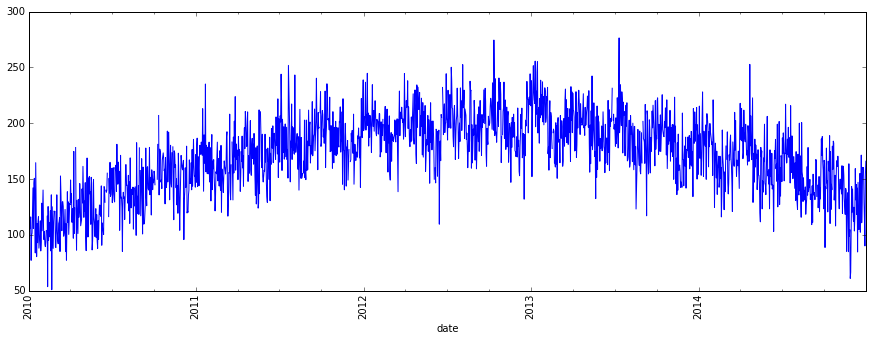

In [7]:
df['car.count'].plot(rot=90, figsize=(15,5))

#### Roughly quadratic over the 5 years, with more interesting shorter trend


### Single Year Analysis: first year on record

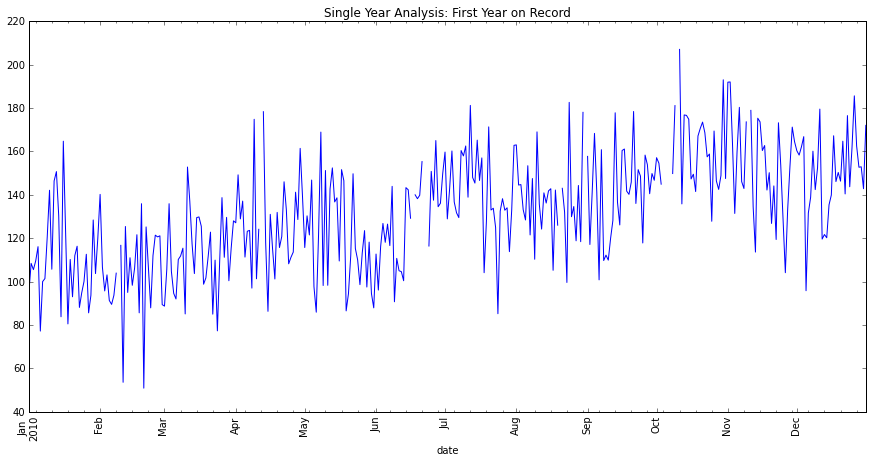

In [9]:
df['car.count'][0:365].plot(rot=90, figsize=(15,7), title="Single Year Analysis: First Year on Record")

Deal with non finite values so we can detrend.

In [10]:
year = df['car.count'][0:365]
year[~np.isfinite(year)]

date
2010-02-09   NaN
2010-04-12   NaN
2010-06-17   NaN
2010-06-22   NaN
2010-06-23   NaN
2010-08-20   NaN
2010-08-31   NaN
2010-10-04   NaN
2010-10-05   NaN
2010-10-07   NaN
2010-10-10   NaN
2010-11-10   NaN
Name: car.count, dtype: float64

In [11]:
# I wasted about 10 minutes going for a vectorized method had to move to brute force
def remove_nans(data):
    for i in range(data.shape[0]):
        if not np.isfinite(data[i]):
            data[i] = data[i-1]
    return data            

year = remove_nans(year)
year_linear_det = signal.detrend(year, axis=0, type='linear')

Single Year Linear Detrend Time Series

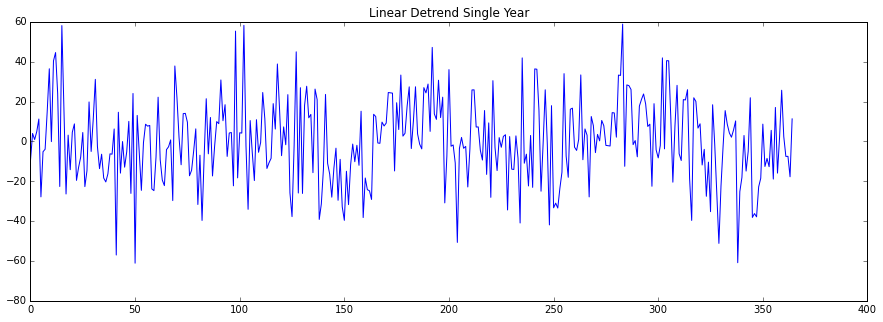

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(year_linear_det)
plt.title("Linear Detrend Single Year")


## Summaries All Data

Group by Month: Global monthly trend averaging over the 5 samples of each month

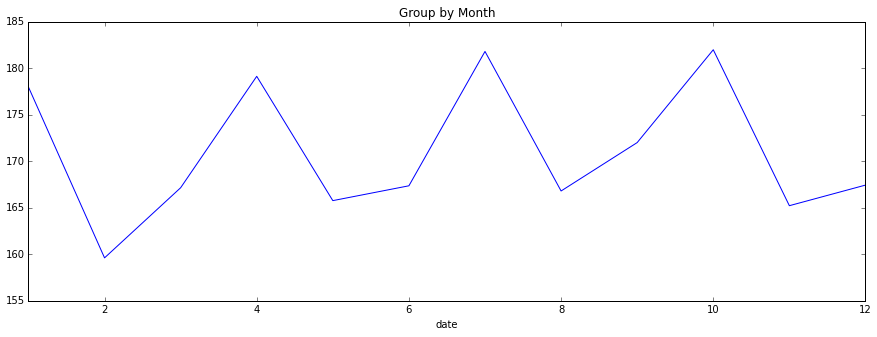

In [16]:
grp = df.groupby(df.date.map(lambda x:x.month))
grp.mean()['car.count'].plot(figsize=(15,5), title="Group by Month")

Group by Year: Global year trend averaging over the 5 samples of each year

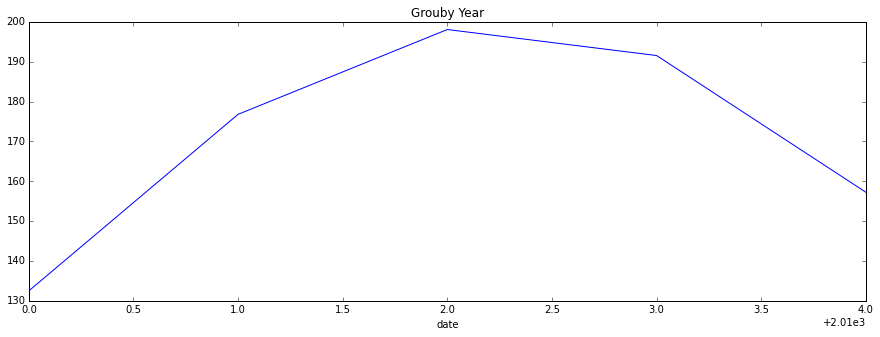

In [17]:
grp = df.groupby(df.date.map(lambda x:x.year))
grp.mean()['car.count'].plot(figsize=(15,5), title="Grouby Year")

Group by Day: Global day trend averaging over the 5 samples of each day

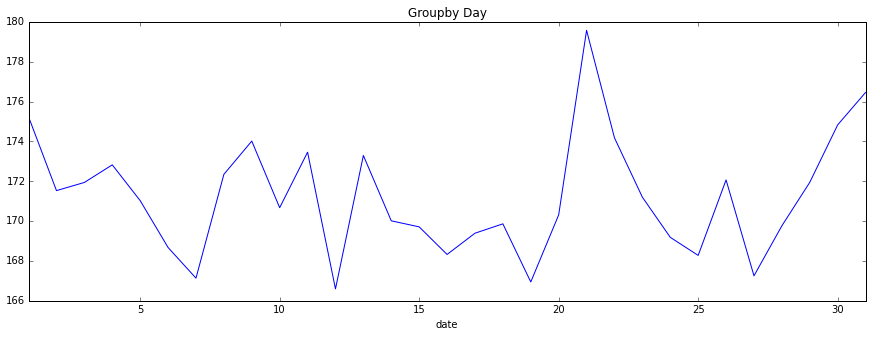

In [18]:
grp = df.groupby(df.date.map(lambda x:x.day))
grp.mean()['car.count'].plot(figsize=(15,5), title="Groupby Day")

## FFT
I keep this method handy, I didn't re-write just cut and paste rather than import so that you can see what's inside.

In [21]:
def fft(data):
        '''Plot FFT using Welch's method, daily resolution '''
        #plt.figure(figsize=(13, 7))
        f, y = signal.welch(data, fs=1.0, nperseg=256, noverlap=128, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) # not working likely b/c of conflict with seaborn artist
        plt.title("Welch FFT: Counts")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs

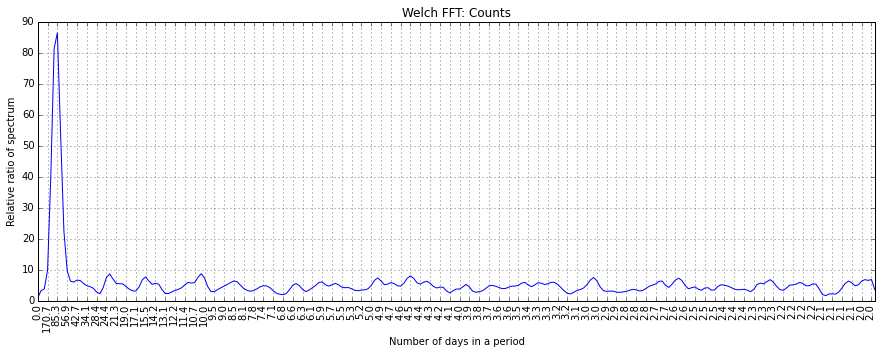

In [22]:
plt.figure(figsize=(15,5))
counts = remove_nans(df['car.count'])
f, y, frqs = fft(counts)

In [248]:
%%bash
date

Mon Mar 14 16:29:43 PDT 2016


# Summary Write Up

Longer time scale:
If we were asked about global count increase, we could use the yearly and fit a quadratic to see that global 
trend.

Shorter time scale:
There's probably a strong correlation with some external related time series data that characterizes typical driving use cases.

Clearly there's an 85 day period with freqency $f = 1/T$ giving $f \approx$ 3 month recurring feature of high counts.

# Future Analysis

I'd like to fit a quadratic to the global time series and report that fit for prediction or detrending purposes.
The Welch FFT shouldn't improve though, because of the sub sampling and linear detrend. The 2nd order curve is rather flat and should look linear in most subsamples.

The Welch FFT I pulled out was not optimized for this data set any known confounds so I'd need to sanity check it more and tweak some values.

# Note About Time

The additional 30 min is mostly from me trying to be clever with vectorizing and reminding myself how I like to use datetime objects in Pandas.

